In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

trainData = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
testData = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [2]:
trainData.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
testData.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here, we see that the test dataset is only useful for the competition organizers, but we cannot use it due to the absence of a "label" column. To address this, I will split the training dataset into training and testing portions.

Firstly some function to import the datasets. getTestDataset can be used for a competition submission.

In [4]:
def getDataset(filePath):
    trainData = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
    trainData = np.array(trainData)
    rows, columns = trainData.shape
    np.random.shuffle(trainData)

    testData = trainData[0:2000].T
    testLabels = testData[0]
    testPixels = testData[1:columns + 1]
    testPixels = testPixels / 255

    trainData = trainData[2000:rows].T
    trainLabels = trainData[0]
    trainPixels = trainData[1:columns + 1]
    trainPixels = trainPixels / 255

    return trainLabels, trainPixels, testLabels, testPixels

def getTestDataset(filePath):
    testData = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
    testPixels = np.array(testData).T
    testPixels = testPixels / 255

    return testPixels

Now, a function to initialize the network's parameters in a random state

In [5]:
def initParams(layerSizes):
    params = {}
    numberOfLayers = len(layerSizes) - 1
    for l in range(1, numberOfLayers + 1):
        params[f"W{l}"] = np.random.rand(layerSizes[l], layerSizes[l - 1]) - 0.5
        params[f"b{l}"] = np.random.rand(layerSizes[l], 1) - 0.5
    return params

Now, some basic functions that will be used in backward and forward propagation

In [6]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def ReluDeriv(Z):
    return Z > 0

def desiredOutputs(Y):
    desiredOut = np.zeros((Y.size, Y.max() + 1))
    desiredOut[np.arange(Y.size), Y] = 1
    desiredOut = desiredOut.T
    return desiredOut

Now, the forward and backward propagation algorithms

In [7]:
def forwardProp(pixels, params, numberOfLayers):
    cache = {"A0": pixels}
    A_prev = pixels

    for l in range(1, numberOfLayers):
        Z = params[f"W{l}"].dot(A_prev) + params[f"b{l}"]
        A = ReLU(Z)
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A
        A_prev = A

    ZL = params[f"W{numberOfLayers}"].dot(A_prev) + params[f"b{numberOfLayers}"]
    AL = softmax(ZL)
    cache[f"Z{numberOfLayers}"] = ZL
    cache[f"A{numberOfLayers}"] = AL
    return cache

def backwardProp(params, cache, pixels, labels, numberOfLayers):
    grads = {}
    desiredOut = desiredOutputs(labels)
    AL = cache[f"A{numberOfLayers}"]

    dZL = AL - desiredOut
    grads[f"dW{numberOfLayers}"] = 1 / pixels.shape[1] * dZL.dot(cache[f"A{numberOfLayers - 1}"].T)
    grads[f"db{numberOfLayers}"] = 1 / pixels.shape[1] * np.sum(dZL, axis=1, keepdims=True)

    dA_prev = params[f"W{numberOfLayers}"].T.dot(dZL)

    for l in range(numberOfLayers - 1, 0, -1):
        dZ = dA_prev * ReluDeriv(cache[f"Z{l}"])
        grads[f"dW{l}"] = 1 / pixels.shape[1] * dZ.dot(cache[f"A{l - 1}"].T)
        grads[f"db{l}"] = 1 / pixels.shape[1] * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = params[f"W{l}"].T.dot(dZ)

    return grads

def updateParams(params, grads, alpha, numberOfLayers):
    for l in range(1, numberOfLayers + 1):
        params[f"W{l}"] -= alpha * grads[f"dW{l}"]
        params[f"b{l}"] -= alpha * grads[f"db{l}"]
    return params

Now, some functions to evaluate results

In [8]:
def getPredictions(AL):
    return np.argmax(AL, 0)

def getAccuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def makePredictions(pixels, params, layerSizes):
    numberOfLayers = len(layerSizes) - 1
    cache = forwardProp(pixels, params, numberOfLayers)
    predictions = getPredictions(cache[f"A{numberOfLayers}"])
    return predictions

def testPrediction(trainLabels, trainPixels, index, params, layerSizes):
    current_image = trainPixels[:, index, None]
    prediction = makePredictions(trainPixels[:, index, None], params, layerSizes)
    label = trainLabels[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Finally, the gradient descent function to train the network.

In [9]:
def gradientDescent(X,Y, alpha, iterations, layerSizes):

    numberOfLayers = len(layerSizes) - 1
    params = initParams(layerSizes)

    iteration = []
    accuracy = []

    for i in range(iterations):
        cache = forwardProp(X, params, numberOfLayers)
        grads = backwardProp(params, cache,X, Y, numberOfLayers)
        params = updateParams(params, grads, alpha, numberOfLayers)

        if i % 10 == 0:
            AL = cache[f"A{numberOfLayers}"]
            predictions = getPredictions(AL)
            print(f"Iteration: {i}, Accuracy: {getAccuracy(predictions, Y)}")
            iteration.append(i)
            accuracy.append(getAccuracy(predictions, Y))

    return params, iteration, accuracy

The neural network can now be created, trained and tested

Iteration: 0, Accuracy: 0.1016
Iteration: 10, Accuracy: 0.141225
Iteration: 20, Accuracy: 0.217675
Iteration: 30, Accuracy: 0.2742
Iteration: 40, Accuracy: 0.341225
Iteration: 50, Accuracy: 0.406925
Iteration: 60, Accuracy: 0.4553
Iteration: 70, Accuracy: 0.496175
Iteration: 80, Accuracy: 0.534725
Iteration: 90, Accuracy: 0.568875
Iteration: 100, Accuracy: 0.598725
Iteration: 110, Accuracy: 0.6271
Iteration: 120, Accuracy: 0.65015
Iteration: 130, Accuracy: 0.669675
Iteration: 140, Accuracy: 0.686175
Iteration: 150, Accuracy: 0.7022
Iteration: 160, Accuracy: 0.714075
Iteration: 170, Accuracy: 0.725
Iteration: 180, Accuracy: 0.7336
Iteration: 190, Accuracy: 0.741325
Iteration: 200, Accuracy: 0.749225
Iteration: 210, Accuracy: 0.756
Iteration: 220, Accuracy: 0.7626
Iteration: 230, Accuracy: 0.768125
Iteration: 240, Accuracy: 0.77355
Iteration: 250, Accuracy: 0.779225
Iteration: 260, Accuracy: 0.7834
Iteration: 270, Accuracy: 0.78755
Iteration: 280, Accuracy: 0.791475
Iteration: 290, Accur

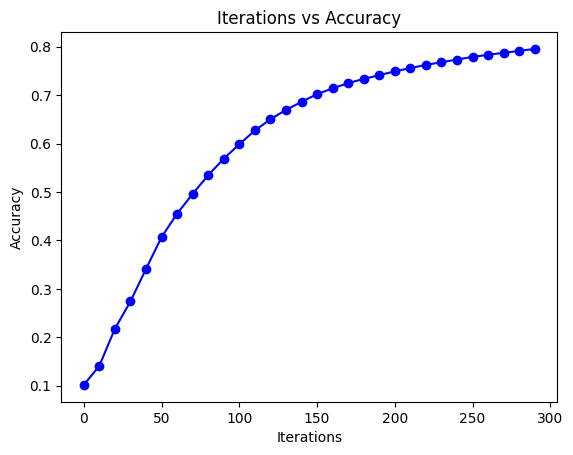

In [10]:
layerSizes = [784, 10, 10]

trainLabels, trainPixels, testLabels, testPixels = getDataset("train.csv")
params, iteration, accuracy = gradientDescent(trainPixels,trainLabels, 0.10, 300, layerSizes)
params['layerSizes'] = layerSizes

plt.plot(iteration, accuracy, marker='o', color='b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Iterations vs Accuracy')
plt.show()

Prediction:  [9]
Label:  4


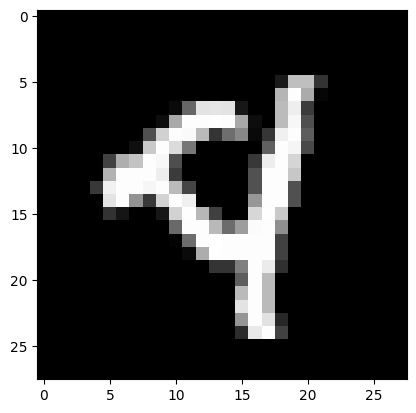

model accuracy : 0.8


In [11]:
testPrediction(trainLabels, trainPixels, 100, params, params['layerSizes'])

testResults = makePredictions(testPixels, params, params['layerSizes'])
print(f"model accuracy : {getAccuracy(testResults, testLabels)}")